# TP 3 : Adversarial Games, Self-Play, Monte Carlo Tree Search

By Diyun Lu and Gwendal Debaussart

In this assignement, we will focus on algorithms that play games.

You will be evaluated on:
* Answering the questions. Bonus points will be given to exploratory answers.
* Implementation of the MCTS. Bonus points will be given to clean, scalable code.

Send this notebook in a html format to cyriaque.rousselot(at)inria(dot)fr before December 15th.

Good Luck !

## Tic-tac-toe

In [1]:
pip install gym==0.21

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from environments import Environment_tic_tac_toe
tic_env = Environment_tic_tac_toe() # Load an instance of Tic-Tac-Toe
tic_env.reset()
tic_env.render()
current_state, reward, is_done, info = tic_env.act(1) # return current state,reward, is the game done ?, informations
tic_env.render()


  |   |  
  |   |  
  |   |  

Turn : O

  |   |  
O |   |  
  |   |  

Turn : X



In [3]:
print("Current state :" ,current_state) # 2 arrays + 1 boolean: (Player1 marks, Player2 marks), Turn
print("Reward : ",reward) # 1 if Player1 win; -1  if player2 win, 0 if draw or if the game continues. 
print("Is the game done",is_done)# True  if the game has ended.
print("Additional information",info)#turn: which player turn  (0 is player 1, 1 is player 2), invalid_moves: occupied squares

Current state : (array([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 1)
Reward :  0
Is the game done False
Additional information {'turn': 1, 'invalid_moves': array([False,  True, False, False, False, False, False, False, False])}


Q.1 Simulate a full game of tic-tac-toe 

In [4]:
tic_env.reset()
i=0
current_state, reward, is_done, info = tic_env.act(0) 
##Simularing a game (with a stupid strategy)
while not is_done :
    i+=1
    tic_env.render()
    current_state, reward, is_done, info = tic_env.act(i) 
    

tic_env.render()

X |   |  
  |   |  
  |   |  

Turn : O

X |   |  
O |   |  
  |   |  

Turn : X

X |   |  
O |   |  
X |   |  

Turn : O

X | O |  
O |   |  
X |   |  

Turn : X

X | O |  
O | X |  
X |   |  

Turn : O

X | O |  
O | X |  
X | O |  

Turn : X

X | O | X
O | X |  
X | O |  

End of the game 



Q.2 Provide a reasonable upper-bound of the size of the state space. Why is it only an upper-bound ? Give a detailed answer

$3^9 \times 2$ seems to be a reasonable upper bound : we have 3 action per square and there is 2 senarios : either cross starts or round starts. It's only a upper bound because some cases will never happen in the game, for example:
<pre>
  |   |           |   |   
O | O | O  and  O | O | O 
X | X | X       X |   |
</pre>
are situations that will never happen.

## Competition of agents

We introduce two agents adapted from previous practicals to play the game of Tic-Tac-Toe. A ```RandomAgent``` that will play random feasable moves and a ```Q_learning_Agent``` that will update its knowledge of the environement.


In [5]:
import numpy as np

class RandomAgent: # A random agent
    def __init__(self,environement):
        self.environement = environement
        self.n_a = environement.n_a # number of possible actions
        self.training = False
        """Init a new agent.
        """

    def memory(self): # Essential for self play
        return None
    def choose(self):
        return(self.environement.uniform_random_action())


    def update(self, observation,action,reward,info):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """
        

In [6]:
# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1
import random
class Q_learning_Agent: # A modified version of Q-learning 
    
    def __init__(self,environement,memory=None):
        self.environement = environement
        self.n_a = environement.n_a
        if memory is not None:
            self.q_table = memory
        else:
            self.q_table = np.zeros([self.environement.env.n_states, self.n_a])
        self.current = 0
        self.training = True
        self.random_a=0
        self.n_a_cho = 0
        
    def get_memory(self):
        return np.copy(self.q_table)
        
    def choose(self):
        self.n_a_cho+=1
        if self.training: # When in training mode
            if random.uniform(0, 1) < epsilon:
                self.random_a+=1
                action = self.environement.uniform_random_action() # Explore action space
                return action
            else:
                action = np.argmax(self.q_table[self.current]) # Exploit learned values
                if self.environement.is_invalid(action):
                    self.q_table[self.current,action] = -np.inf # Remove the impossible action
                    self.random_a+=1
                    action = self.environement.uniform_random_action()
            return action
        
        else : # Outside of training mode 
            action=np.argmax(self.q_table[self.current])
            counter_action = 1

            if random.uniform(0, 1) < epsilon:
                self.random_a+=1
                action = self.environement.uniform_random_action()
                return action

            while self.environement.is_invalid(action):
                counter_action += 1
                self.q_table[self.current,action] = -np.inf
                if counter_action > self.n_a:
                    self.random_a+=1
                    action = self.environement.uniform_random_action()
                else:
                    action=np.argmax(self.q_table[self.current])
            return action

    def reset_random_counter(self):
        "Reset the counters of actions and random actions"
        self.random_a = 0
        self.n_a_cho = 0
    
    def get_random_counter(self):
        "Return the number of time the algorithm chose an action randomly"
        return (self.random_a,self.n_a_cho)

    def update(self, observation,action,reward,info):
        """Receive a reward for performing given action on
        given observation.
gamma
        This is where your agent can learn.
        """
        if self.training:
            old_value = self.q_table[self.current, action]
            next_max = np.max(self.q_table[obs_to_int(observation)])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            self.q_table[self.current, action] = new_value
        self.current = obs_to_int(observation)

def obs_to_int(obs): # Convert our state representation  into an integer
    array,turn =obs
    
    b = array.flatten()
    return int((b.dot(2**np.arange(b.size)[::-1]+1)+1)*(turn+1))    

Q (BONUS) Suggest a better method for the q_table implementation.

implementation ... TODO

We will now use a ```Runner``` object to train our agent against himself : The reward seen by the agent when playing as player 2 will be the opposite of the effective reward. 


In [7]:
from runner import Runner,Runner_eval_vs,Runner_train_vs
from environments import Environment_tic_tac_toe,Environment_go

my_env = Environment_tic_tac_toe()
my_agent_random = RandomAgent(my_env)
my_agent_q = Q_learning_Agent(my_env)


In [8]:
my_env.reset()# Reset the environement

runner_rd = Runner(my_env,my_agent_random,verbose=True)# Verbose is set to true to generate a display string with the full match
list_reward_random,display = runner_rd.loop(5) # List reward : the rewards  we get at the end of the games,
my_env.render()                                                #    display: text rendering of the games

  |   |  
  |   |  
  |   |  

Turn : O



In [9]:
with open("rapport_partie_rd.txt",'w', encoding = 'utf-8') as f: # Write the games into a txt file
    f.write(display)


In [10]:
# Training the Q-agent against itself. 
runner_q = Runner(my_env,my_agent_q,False,training=True)
list_reward_q,_ = runner_q.loop(10000) # Can take a while

<BarContainer object of 100 artists>

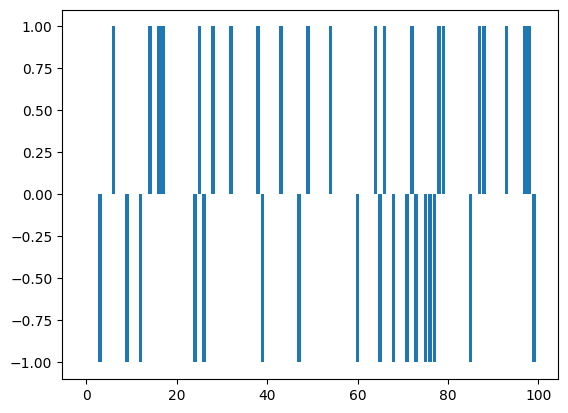

In [11]:
import matplotlib.pyplot as plt 
plt.bar(range(len(list_reward_q[-100:])),list_reward_q[-100:])

In [12]:
# Visualize Q-learning Agent games
my_env.reset()

runner_q_d = Runner(my_env,my_agent_q,True,training=False)# Verbose is set to true to generate a display string with the full match
_,display = runner_q_d.loop(10)

In [13]:
with open("rapport_partie_q.txt",'w', encoding = 'utf-8') as f: # Write the games into a txt file
    f.write(display)


Q.3 Compare the games of the Random agent and of the Q-learning agent.

The random agent's game seems to end more with either of one player winning the game, wheras the game with the Q-Agent seems to end up often with a tie

Q.4 What can you say about the Q-Learning agent games ? Is the Agent performing well ?

The Q-Agent game seems to end with ties, the agent seems to perform well enough against itself

## Evaluate our Q-Agent against a random Agent

In [14]:
my_agent_q.reset_random_counter()
eval_runner = Runner_eval_vs(my_env,my_agent_q,my_agent_random) # Evaluate the agent my_agent_q against the random agent my_agent_random
list_match_q_rd,_ = eval_runner.loop(1000)
random_n,n = my_agent_q.get_random_counter()
print(random_n,n)

383 4006


In [15]:
tic_env.reset()
my_agent_q.reset_random_counter()
eval_runner = Runner(my_env,my_agent_q,Q_learning_Agent(tic_env,my_agent_q.get_memory())) # Evaluate the agent my_agent_q against the random agent my_agent_random
list_match_q_rd,_ = eval_runner.loop(1000)
random_n,n = my_agent_q.get_random_counter()
print(random_n,n)


838 8882


In [16]:
# Counting the wins,losses and draw of the first evaluated agent
list_match= np.array(list_match_q_rd)
count_agent_q = np.count_nonzero(list_match == 1.0)
count_agent_rd = np.count_nonzero(list_match == -1.0)
count_null = np.count_nonzero(list_match == 0.0)
total = np.shape(list_match)[0]

print("Percentage of win of Agent Q : ",count_agent_q/total)
print("Number of win of Random Agent  : ",count_agent_rd/total)
print("Number of null : ",count_null/total)

Percentage of win of Agent Q :  0.111
Number of win of Random Agent  :  0.108
Number of null :  0.781


In [17]:
my_agent_q.reset_random_counter()
eval_runner = Runner(my_env,my_agent_q,Q_learning_Agent(tic_env,memory=my_agent_q.get_memory())) # Evaluate the agent my_agent_q against a copy of itself
list_match_q_q,_ = eval_runner.loop(1000)
random_n,n = my_agent_q.get_random_counter()
print(random_n,n)

894 8866


Q.5 Using the ```get_random_counter(), reset_random_counter() ``` method to count the number of random decisions of the Q_learning agent, what can you say about the decisions of the Q_learning agent against himself ? Against a Random Agent ? Why ?

it would seem that the Q-Agent plays more randomly against it-self than against a random Agent. It's surely due to the fact that when the Q-agent is against itself it has multiple possibility of "good choice" or possibility that would lead to a tie, where as against a random agent, the good actions may be a bit more rare. Also, the Q-Learning don't know in advance whqt the random agent will do.

Q.6 Conclude on why  our adapted Q_learning agent is performing poorly against a random agent

Because the Q-Learning was trained against itself, thus it learnt to play good against it's own strategy and not against any strategy.

Q.7 Suggest a method to improve the performance of the Q-learning agent. Bonus points will be given to implementation.

Maybe by training the Q-Agent in competition with other agent could help it perform better

## Monte Carlo Tree Search

https://en.wikipedia.org/wiki/Monte_Carlo_tree_search

The MCTS algorithm we will implement can be divided in 4 steps:
- Selection 
- Expansion
- Simulation
- Backpropagation

The first step is exploring the current tree using a UCB rule until we get to a leaf L .

The second is creating a child C from feasable moves after the leaf L if the game is not finished.

The third is simulating the end of the game with an unbiased method to get an estimate of the value of the position C.

The fourth is updating the value estimation of the position of all nodes visited during the exploration of the tree.


Points will be granted even if the end algorithms doesn't run.

In [18]:
from environments import Environment_tic_tac_toe

tic_env = Environment_tic_tac_toe()

In [19]:
import numpy as np
def obs_to_int(obs): # Convert our binary representation of arrays into an integer
    array,turn =obs
    
    b = array.flatten()
    return int((b.dot(2**np.arange(b.size)[::-1]+1)+1)*(turn+1))     

In [20]:
#Building the Tree Structure Recursively

class Node:
    def __init__(self,observation, parent=None, action=None):
        self.parent = parent # Which Node is the parent
        self.action = action # What action is associated to this Node
        self.state = obs_to_int(observation) # What state is associated to this Node
        self.children = [] # What are the children Nodes of this Node
        self.explored_children = 0 # The number of children we explored
        self.n_visits = 0 # Tje amount of time we have visited this Node
        self.results = {-1:0,0:0,1:0} 
    def value(self):
        return self.results[1]-self.results[-1]
    def __str__(self):
        return "Node("+'c: ['+" ".join([i.__str__() for i in self.children])+']'+', a:'+str(self.action)+', s:'+str(self.state)+")"

In [21]:
#Observing the building of the tree

obs = tic_env.reset()
Root = Node(observation=obs) # We convert every array representation of state into an integer.
print("Initial Tree :",Root)
action_0=2

obs, reward, done, info = tic_env.act(action_0)
Node_action_0 = Node(obs,Root,action_0)
Root.children.append(Node_action_0)
tic_env.render()
print("Current Tree :",Root)

action_1=5
obs, reward, done, info = tic_env.act(action_1)
Leaf_action_1 = Node(obs,Node_action_0,action_1)
tic_env.render()
Node_action_0.children.append(Leaf_action_1)
print("Current Tree :",Root)

Initial Tree : Node(c: [], a:None, s:2)
  |   |  
  |   |  
X |   |  

Turn : O

Current Tree : Node(c: [Node(c: [], a:2, s:66)], a:None, s:2)
  |   |  
  |   |  
X | O |  

Turn : X

Current Tree : Node(c: [Node(c: [Node(c: [], a:5, s:8326)], a:2, s:66)], a:None, s:2)


Q.8 Using the UCB valuation, build a function selection that select the best possible child among children of a node

In [22]:
def ucb(node,c=0.1):
    return node.value() / node.n_visits + np.sqrt(c*np.log(node.parent.n_visits)/node.n_visits)

# def selection(node):
#     selected_child = np.argmax(ucb(node.children)) # TO COMPLETE
#     return selected_child

def selection(node):
    # calculate the ucb values for each children nodes.
    ucb_values = []
    for child in node.children:
        ucb_value = ucb(child)
        ucb_values.append(ucb_value)

    selected_child = node.children[np.argmax(ucb_values)]
    return selected_child


Q.9 Build an Expansion function that generates a new child from feasable actions, add it to the children of the node. You may use the ``` invalid_moves()``` method from the Environment class. You will generate the new child along running the environement. You can't generate one child if there is already an existing child with the same associated action. 

In [23]:
def expansion(node,env):
    new_child = node
    # possible_actions = [env.uniform_random_action() for _ in range(env.n_a)]
    valid_actions = [index for index, a in enumerate(my_env.invalid_moves()) if a == False]
    # check if the action already exists
    is_existed = True
    for action in valid_actions:
        is_existed = False
        for child in node.children:
            if child.action == action:
                is_existed = True
                break
    # if it doesn't exist, then we get the next observation
    if not is_existed:
        next_observation, reward, done, info = env.act(action)
        # and we can create a new child node
        new_child = Node(next_observation, parent=node, action=action)
        node.children.append(new_child)
    
    return new_child

Q.10 Build a simulation function (rollout) that simulate the rest of the game until the end. It will return the outcome of the game.  You may use the ```uniform_random_action(),is_done(),act()``` method from the Environment class. You have to compare the finishing turn to the starting turn ```env.init_turn``` to give a proper reward to the end game.

In [24]:
def simulation(node,env):
    reward = 0
    # if the game is not over, then do the simulation
    while not env.is_done():
        # choose an action
        action = env.uniform_random_action()
        # run the action
        env.act(action)
    # compute the reward
    if env.init_turn == env.turn():
        reward = 1
    else:
        reward = -1
    return reward

Q.11 Build a backpropagation function that update for the  node visited the number of visits, and the number of losses, draw and win 

In [25]:
def backpropagation(node:Node,result):
    # if current node has father, then continue the recursion
    if node.parent:
        backpropagation(node.parent,result)
    # update the visited numbers
    node.n_visits += 1
    # update the results
    node.results[result] += 1

Q.12 Build a function that follows the tree and return a leaf. While the game is not finished, the function verify if all possible children of the current node exists(looking at feasable moves), and select the best child from them

In [26]:
def in_the_tree_policy(node:Node,env): 
    current_node = node
    while not env.is_done():
        # if all the possible children nodes are existed of current node, then we will choose the best child.
        possible_actions = [env.uniform_random_action() for _ in range(env.n_a)]
        valid_actions = [a for a in possible_actions if a not in env.invalid_moves()]
        # possible_actions = [action_to_function(action) for action in actions]
        if len(current_node.children) == len(valid_actions):
            current_node = selection(current_node)
        # Otherwise, we expand current node and return the new node
        else:
            return expansion(current_node, env)
    return current_node


Q.13 Build a function choose_action that perform rollouts from a node,  find a leaf in the tree using ```in_the_tree_policy()```,simulate its result and backpropagate after ```n_rollouts``` iterations. You may need to use the ```deepcopy``` function to pass a copy of the environement for the roll-out.

In [38]:
from copy import deepcopy
def choose_action(node:Node,env):
    n_rollouts = 200 # Number of rollout to perform before backpropagation (originally 100)
	
    for i in range(n_rollouts):
        rolling_env = deepcopy(env)
        leaf = in_the_tree_policy(node, rolling_env)
        reward = simulation(leaf, rolling_env)
        backpropagation(leaf, reward)
    return selection(node).action

Q.14 Finalize your MCTS algorithm and launch it on the Tic Tac Toe Environement.

In [39]:
from copy import deepcopy
class MCTS:
    def __init__(self,environement,memory=None):
        self.tree = Node(environement.reset())
        self.n_a = environement.n_a
        self.environement = environement
        self.current_node = self.tree
        self.training = False

    def get_memory(self):
        return deepcopy(self.tree)
        
    def choose(self): # Select the next good action
        action = choose_action(self.current_node,self.environement)
        return action

    def update(self, observation,action,reward,info):
        # find the children node that is associated with current node
        next_node = None
        for child in self.current_node.children:
            if child.action == action:
                next_node = child
                break
        # if the next_node is not existed, then we create a new node
        if not next_node:
            next_node = Node(observation, parent=self.current_node, action=action)
            self.current_node.children.append(next_node)
        # update current node
        self.current_node = next_node
        
    
my_MCTS = MCTS(tic_env)


Q.15 Evaluate your MCTS against other policies

In [42]:
eval_runner = Runner_eval_vs(my_env,my_MCTS,my_agent_random) # Evaluate the agent my_MCTS against the random agent my_agent_random
list_match_MCTS_rd,_ = eval_runner.loop(100)
random_n,n = my_agent_q.get_random_counter()

tic_env.reset()
eval_runner = Runner(my_env,my_agent_q,False,training=False) # Evaluate the agent my_agent_q against the random agent my_agent_random
#eval_runner = Runner_eval_vs(my_env,my_agent_q,my_agent_random)
list_match_q_rd,_ = eval_runner.loop(100)
random_n,n = my_agent_q.get_random_counter()

# Counting the wins,losses and draw of the first evaluated agent
list_match= np.array(list_match_MCTS_rd)
count_agent_MCTS = np.count_nonzero(list_match == 1.0)
count_agent_rd = np.count_nonzero(list_match == -1.0)
count_null = np.count_nonzero(list_match == 0.0)
total = np.shape(list_match)[0]

print("Percentage of win of Agent MCTS : ",count_agent_MCTS/total)
print("Number of win of Random Agent  : ",count_agent_rd/total)
print("Number of null : ",count_null/total)

list_match_q= np.array(list_match_q_rd)
count_agent_q = np.count_nonzero(list_match_q == 1.0)
total = np.shape(list_match_q)[0]
print("Number of win of Random Q  : ", count_agent_q/total)

Percentage of win of Agent MCTS :  0.55
Number of win of Random Agent  :  0.43
Number of null :  0.02
Number of win of Random Q  :  0.16
